# Fourier analysis

This notebook demonstrates the typical spatial frequencies found in QAOA.

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qaoa import *
from pylab import cm

from matplotlib import rc,patches
from scipy import optimize as opt

# Sampling parameters
SAMPLING_E_ATOL = 1e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-2
MIN_SAMPLES = 256
MAX_SAMPLES = 32768*32
SAMPLING_CONF_IDX = 3
LANDSCAPE_RESOLUTION = 12

# Other parameters
WEIGHT_DECIMALS = 1
CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

100%
Max cost: 3


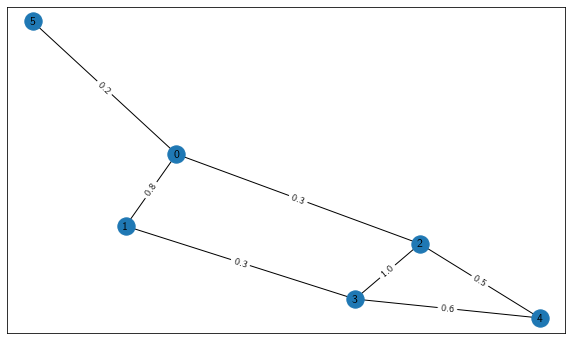

In [2]:
V = np.arange(0,6,1)
E =[(0,1),(0,2),(2,3),(3,1),(3,4),(4,2),(0,5)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
addWeights_MaxCut(G,decimals=WEIGHT_DECIMALS)
weights = [G[i][j]['weight'] for i,j in G.edges()]

pl.figure(figsize=(10,6))
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')

Calculate the typical maximum frequencies and use this to choose the number of sampling points.

In [4]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=WEIGHT_DECIMALS)
gamma_period = (gamma_max-gamma_min)*2
beta_period = beta_max-beta_min

gamma_typ_freq,beta_typ_freq = spatialFrequencies_MaxCut(G)

landscape_n_gamma = int(gamma_period*LANDSCAPE_RESOLUTION*np.ceil(gamma_typ_freq))
landscape_n_beta = int(beta_period*LANDSCAPE_RESOLUTION*np.ceil(beta_typ_freq))
landscape_delta_gamma = (gamma_max-gamma_min)/landscape_n_gamma
landscape_delta_beta = (beta_max-beta_min)/landscape_n_beta

print('gamma_typ_freq: %.2f' % gamma_typ_freq)
print('beta_typ_freq: %.2f' % beta_typ_freq)
print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)

gamma_typ_freq: 0.25
beta_typ_freq: 0.78
landscape_n_gamma: 753
landscape_n_beta: 18


In [5]:
gammas_landscape = np.linspace(gamma_min,gamma_max,landscape_n_gamma)
betas_landscape = np.linspace(beta_min,beta_max,landscape_n_beta)

E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
circuits=[]
for i in range(landscape_n_beta):
    for j in range(landscape_n_gamma):
        beta = betas_landscape[i]
        gamma = gammas_landscape[j]
        circuit = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
        [E_list,_,_] = sampleUntilPrecision_MaxCut(circuit,G,backend_sim,None,MIN_SAMPLES,
                                                             MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                             SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
        E_landscape[i,j] = -E_list[-1]
        print('%.2f%%' % ((i*landscape_n_gamma+j)*100/(landscape_n_gamma*landscape_n_beta)),end='\r')
        

First visualize the landscape to predict approximately what is the frequency support.

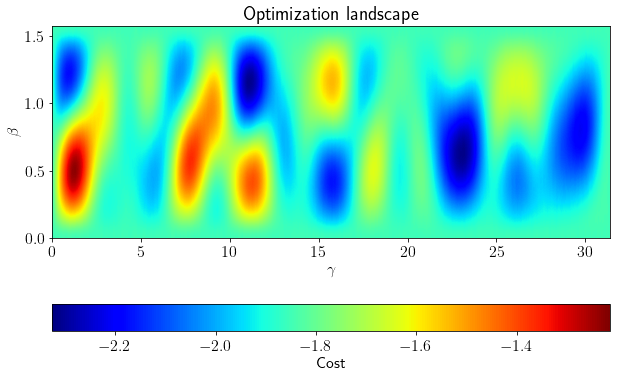

In [6]:
pl.figure(figsize=(10,6))
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Cost')

pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')
pl.savefig('fourier_landscape.svg')

Show the frequency spectrum and the predicted support.

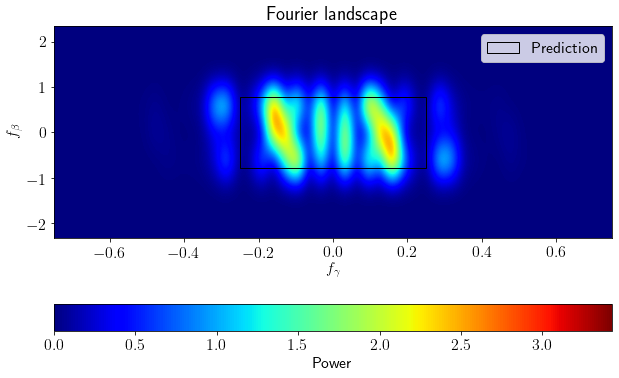

In [7]:
E_landscape_mean = np.mean(E_landscape)
Efreq_landscape = np.abs(np.fft.fft2(E_landscape-E_landscape_mean)*landscape_delta_gamma*landscape_delta_beta)**2
gamma_freqs = np.fft.fftfreq(landscape_n_gamma,landscape_delta_gamma)
beta_freqs = np.fft.fftfreq(landscape_n_beta,landscape_delta_beta)

Efreq_landscape = np.fft.fftshift(Efreq_landscape)
gamma_freqs = np.fft.fftshift(gamma_freqs)
beta_freqs = np.fft.fftshift(beta_freqs)

pl.figure(figsize=(10,6))
pl.imshow(np.array(Efreq_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gamma_freqs[0],gamma_freqs[-1],beta_freqs[0],beta_freqs[-1]])
prediction_rect = patches.Rectangle((-gamma_typ_freq,-beta_typ_freq),2*gamma_typ_freq,2*beta_typ_freq,
                                    linewidth=1,edgecolor='k',facecolor='none',label='Prediction')
pl.gca().add_patch(prediction_rect)
pl.legend()

cbar = pl.colorbar(orientation="horizontal", pad=0.2)
cbar.set_label('Power')

pl.xlabel(r'$f_\gamma$')
pl.ylabel(r'$f_\beta$')
pl.title('Fourier landscape')
pl.xlim(-3*gamma_typ_freq,3*gamma_typ_freq)
pl.ylim(-3*beta_typ_freq,3*beta_typ_freq)
pl.savefig('fourier_2d.svg')

Now sum over each orthogonal axis for 1D plots.

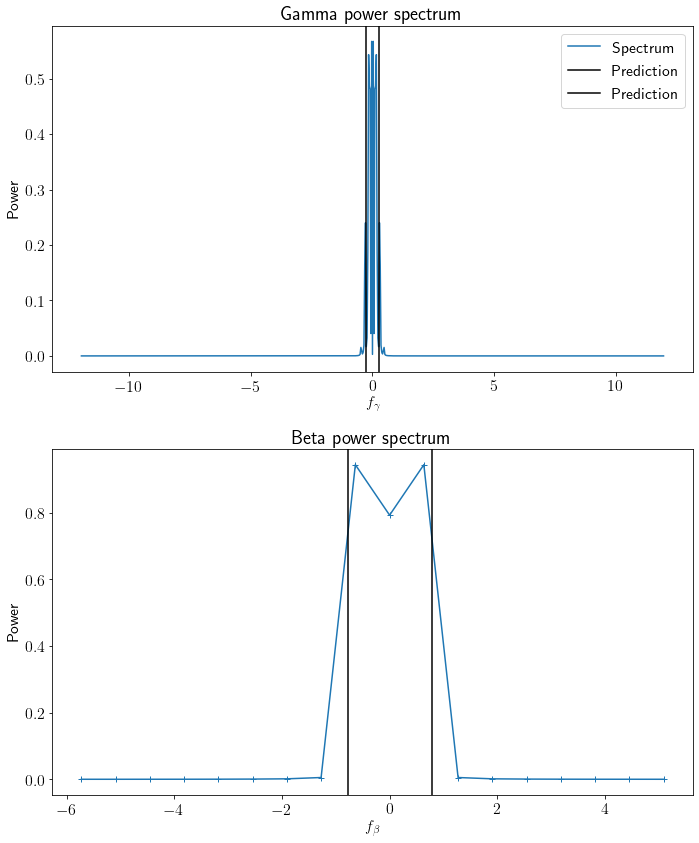

In [12]:
gamma_power = np.trapz(Efreq_landscape,axis=0,dx=landscape_delta_beta)
beta_power = np.trapz(Efreq_landscape,axis=1,dx=landscape_delta_gamma)

pl.figure(figsize=(10,12))
pl.subplot(2,1,1)
pl.plot(gamma_freqs,gamma_power,label='Spectrum')
pl.axvline(gamma_typ_freq,linestyle='-',color='k',label='Prediction')
pl.axvline(-gamma_typ_freq,linestyle='-',color='k',label='Prediction')
pl.xlabel(r'$f_\gamma$')
pl.ylabel(r'Power')
pl.title('Gamma power spectrum')
pl.legend()

pl.subplot(2,1,2)
pl.plot(beta_freqs,beta_power,'-+',label='Spectrum')
pl.axvline(beta_typ_freq,linestyle='-',color='k',label='Prediction')
pl.axvline(-beta_typ_freq,linestyle='-',color='k',label='Prediction')
pl.xlabel(r'$f_\beta$')
pl.ylabel(r'Power')
pl.title('Beta power spectrum')

pl.tight_layout()
pl.savefig('fourier_1d.svg')